# What is anomaly detection?
Anomaly detection is any process that finds the outliers of a dataset; those items that don’t belong. These anomalies might point to unusual network traffic, uncover a sensor on the fritz, or simply identify data for cleaning, before analysis.


In [298]:
# import Packages:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

## GMM with synthetic data for the purpose of visualization:
## GMM: Anomaly Detection

We can use GMM for anomaly detection.

First, compute the likelihood (or log-likelihood) of the given data X (using the "score" method). Then, any instance located in a low-density region can be considered an anomaly. 

To decide whether a data point resides in a reasonable "low-density" region, we need to define a **density threshold**.

We use the following example from Geron (Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition) to illustrate **how to decide a threshold density**.

In [316]:
X1, y1 = make_blobs(n_samples=1000, centers=((6, -6), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
noise = np.random.normal(1, 3, size=(150, 2))
y3 = np.ones(len(noise))
X = np.r_[X1, X2, noise]
y = np.r_[y1, y2, y3]

In [280]:
print(X[:5])

[[ 0.81672911  1.32719052]
 [ 0.28671649  1.30485269]
 [-2.61404675  0.69530197]
 [ 0.4180268   1.03495115]
 [-3.47196489  0.54295907]]


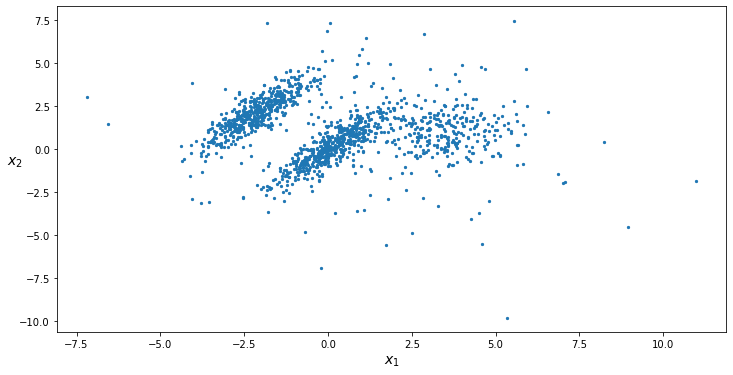

In [261]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap='autumn')
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(12, 6))
plot_clusters(X)
plt.show()

In [262]:
import pandas as pd
df = pd.DataFrame(X)
df.head()

,0,1
0,0.816729,1.327191
1,0.286716,1.304853
2,-2.614047,0.695302
3,0.418027,1.034951
4,-3.471965,0.542959


**We will use the gaussian mixture model as our basis of anomaly detection**

The basic idea is to find points with low log-likelihood.

In [264]:
gmm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gmm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [265]:
densities = gmm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

In [266]:
# densities = gmm.score_samples(df)
# probabilities = []
# for i in range(len(densities)):
#     probabilities.append(densities[i].max())
    
# probabilities = np.array(probabilities)
# anomalies = df[probabilities < 0.55]

In [267]:
anomalies.shape

(56, 2)

In [268]:
clusters = gmm.predict(X)
df['clusters'] = clusters

<AxesSubplot:xlabel='0', ylabel='1'>

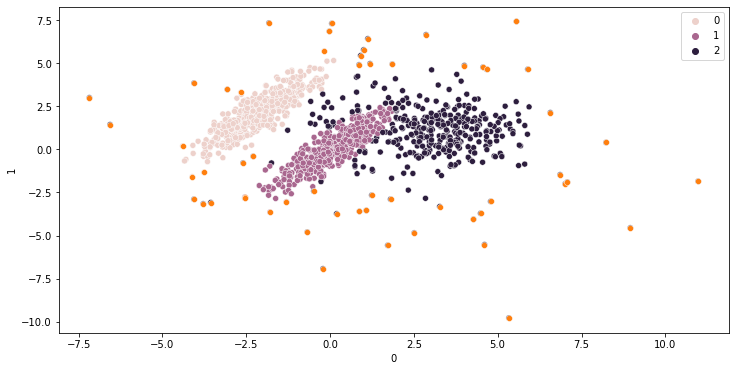

In [269]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.scatterplot(x=0, y=1, data=df, hue='clusters')
sns.scatterplot(x=0, y=1, data=df[densities < density_threshold])

In [270]:
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=5, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=50,
                color=cross_color, zorder=11, alpha=1)


def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

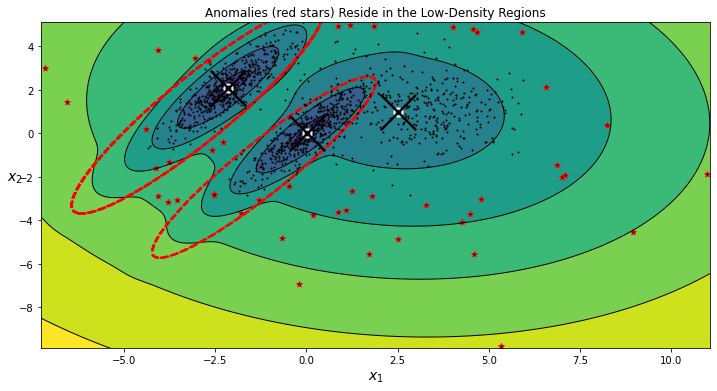

In [271]:
plt.figure(figsize=(12, 6))
plt.title("Anomalies (red stars) Reside in the Low-Density Regions")

plot_gaussian_mixture(gmm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

___
# GMM With a multidimensional dataset, from ODDS(cardio dataset)

In [272]:
import scipy.io
mat = scipy.io.loadmat('cardio.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC', '__version__': '1.0', '__globals__': [], 'X': array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
        -0.28978574, -0.49329397],
       [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
        -0.25638541, -0.49329397],
       [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
        -0.25638541,  1.14001753],
       ...,
       [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
         0.24461959, -0.49329397],
       [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
         0.14441859, -0.49329397],
       [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
         3.58465295, -0.49329397]]), 'y': array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])}


In [273]:
import pandas as pd
df = pd.DataFrame(mat['X'])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,1.485973,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,1.485973,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,1.141780,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,1.141780,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.208514,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018


In [274]:
gmm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gmm.fit(df)

GaussianMixture(n_components=3, n_init=10, random_state=42)

In [275]:
densities = gmm.score_samples(df)
density_threshold = np.percentile(densities, 9.6)
anomalies = df[densities < density_threshold]

In [300]:
print(anomalies.shape, '\n')
anomalies.head()

(176, 21) 



,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
5,-0.100905,1.375314,4.484914,0.480556,-0.191869,-0.061401,-0.278295,-0.992364,0.064200,-0.420487,...,0.347490,-0.691466,-0.345328,-0.753395,-0.488279,0.301464,0.256962,0.300465,-0.356586,1.140018
6,-0.206722,0.556293,8.394663,-0.177408,0.942922,-0.061401,1.104416,-1.411143,0.990697,-0.420487,...,0.877017,-0.834013,0.534694,0.966637,-0.488279,0.421696,-0.509216,-0.113338,1.847836,-0.493294
7,-0.206722,0.488735,7.812426,-0.174564,0.674478,-0.061401,2.030717,-1.530793,0.990697,-0.420487,...,0.877017,-0.834013,0.534694,-0.409388,-0.488279,-0.119345,-0.381519,-0.251273,0.745625,-0.493294
8,-0.206722,0.619530,9.102203,-0.038887,0.800571,-0.061401,-0.278295,-1.231666,0.759072,-0.420487,...,1.353591,-1.332931,0.754700,0.278625,-0.488279,0.421696,-0.317671,0.093563,1.647434,1.140018
9,-0.206722,-0.200598,9.302999,0.354112,0.703456,-0.061401,2.079984,-1.291492,0.527448,-0.420487,...,0.665206,-1.119109,-0.345328,0.622631,-0.488279,-0.179460,-0.573064,-0.527142,0.511822,1.140018


___
# Using Pyod module to find outliers:

In [301]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix 

# Importing KNN module from PyOD
from pyod.models.knn import KNN 
from pyod.models.ocsvm import OCSVM 

# Import the utility function for model evaluation
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [343]:
X1, y1 = make_blobs(n_samples=1000, centers=((6, -6), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

noise = np.random.normal(5, 3, size=(15, 2))
y1 = y1*0
y2 = np.ones(len(noise))
X = np.r_[X1, noise]
y = np.r_[y1, y2]

In [344]:
#split the data into train and test 

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state=42 )

In [350]:
# create the KNN model
# contamination value is 0.012 (1.2%)
clf_name = 'KNN'
clf_knn = KNN(contamination=0.012, n_neighbors = 5,n_jobs=-1)

clf_knn.fit(X_train)

KNN(algorithm='auto', contamination=0.012, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
  radius=1.0)

In [351]:
# Get the prediction labels of the training data
y_train_pred = clf_knn.labels_  # binary labels (0: inliers, 1: outliers)

# Outlier scores
y_train_scores = clf_knn.decision_scores_ 
y_train_pred = clf_knn.predict(X_train)
# Evaluate on the training data
evaluate_print('KNN', y_train, y_train_scores) 


KNN ROC:0.9964, precision @ rank n:0.8333


In [352]:
y_test_scores = clf_knn.decision_function(X_test)  # outlier scores
y_test_pred = clf_knn.predict(X_test)
# Evaluate on the training data
evaluate_print('KNN', y_test,y_test_scores) 

KNN ROC:1.0, precision @ rank n:1.0


In [353]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       800
         1.0       1.00      0.83      0.91        12

    accuracy                           1.00       812
   macro avg       1.00      0.92      0.95       812
weighted avg       1.00      1.00      1.00       812



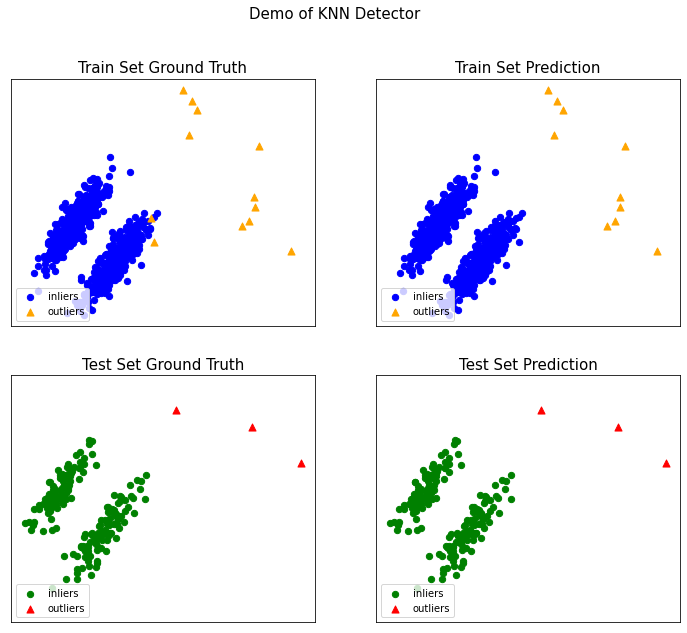

In [354]:
# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
              y_test_pred, show_figure=True, save_figure=True)

___
# Conclusion:

**GMM:** \
it's a good algorithm for anomaly detection, but we need  a good domain knowledge for detecting GMM hyperparameters.

**KNN in Pyod library:** \
For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score.\
PyOD supports three kNN detectors:
* Largest: Uses the distance of the kth neighbor as the outlier score
* Mean: Uses the average of all k neighbors as the outlier score
* Median: Uses the median of the distance to k neighbors as the outlier score